In [2]:
import pandas as pd
from xgboost import XGBRegressor as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import sklearn
import seaborn as sns
from sklearn.model_selection import KFold 

In [3]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [12]:
# df['time'] = df['Hour']*100 + df['Minute']
# df_test['time'] = df_test['Hour']*100 + df_test['Minute']

In [4]:
# df['GHI_cal'] = df['Clearsky DNI']*np.cos(np.radians(df['Solar Zenith Angle'])) + df['Clearsky DHI']

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

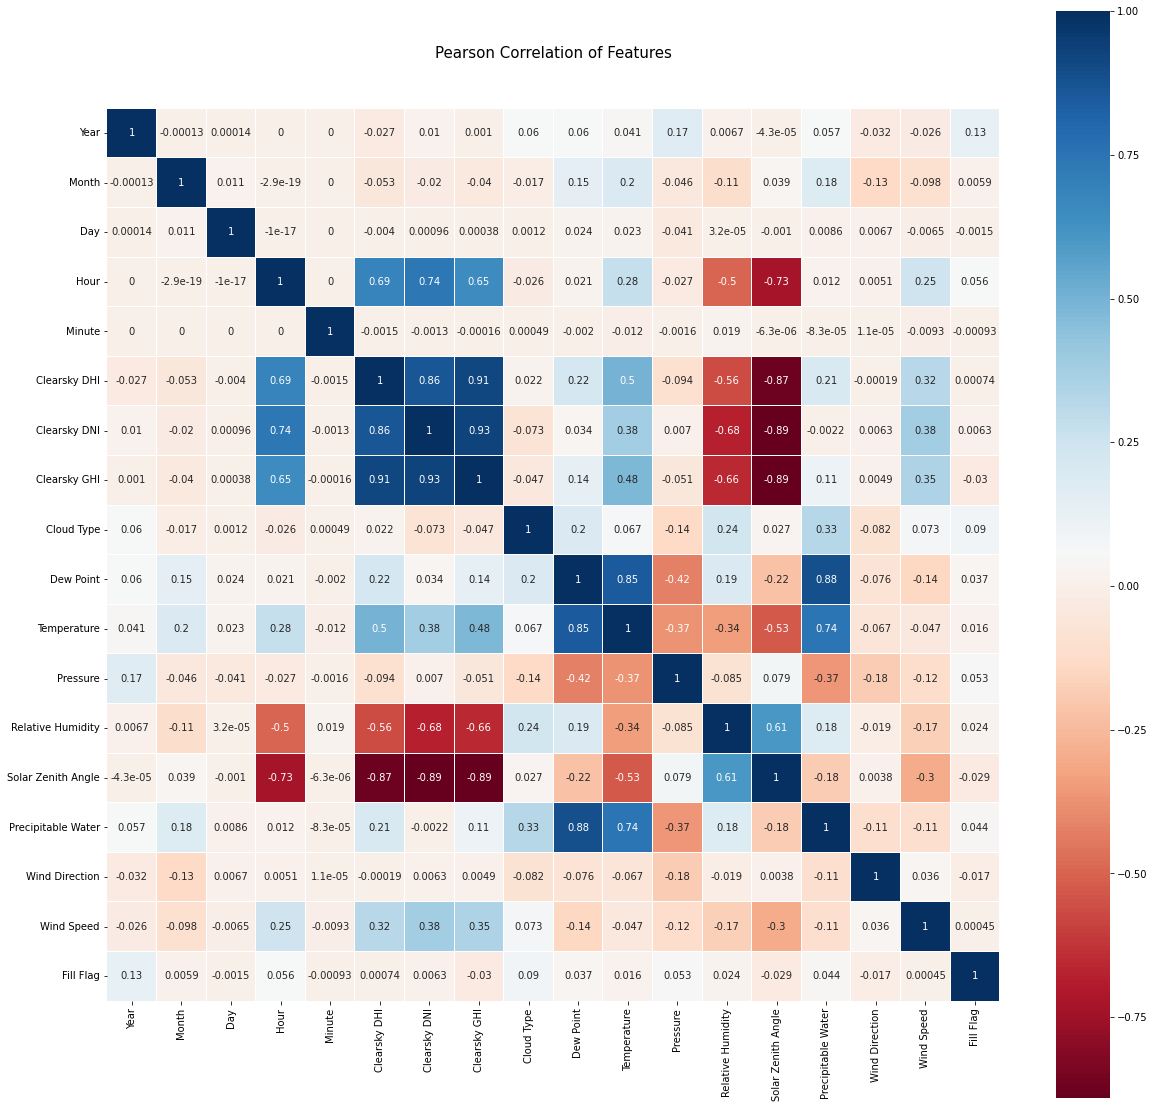

In [5]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [6]:
skf = KFold(n_splits=5,shuffle=True,random_state=42)
df["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(df)):
   df.iloc[val_index, -1] = fold_id

In [7]:
oof_pred = pd.DataFrame(columns = ['DHI', 'DHI_pred', 'DNI', 'DNI_pred','GHI','GHI_pred'])

In [19]:
DHI_test = np.zeros(17520)
DNI_test = np.zeros(17520)
GHI_test = np.zeros(17520)

In [20]:
from tqdm import tqdm 

In [21]:
for fold in tqdm([0,1,2,3,4]):
    print(fold)
    oof_pred_cr = pd.DataFrame(columns = ['DHI', 'DHI_pred', 'DNI', 'DNI_pred','GHI','GHI_pred'])
    #Preparing train, validation and test set
    df_train = df.loc[df.fold != fold]
    df_val = df.loc[df.fold == fold]

    y_train_DHI = df_train['Clearsky DHI']
    y_train_DNI = df_train['Clearsky DNI']
    y_train_GHI = df_train['Clearsky GHI']
    x_train = df_train.drop(['Clearsky DHI', 'Clearsky DNI','Clearsky GHI','Hour',
                             'Minute','fold'], axis = 1)
#     x_train = df_train.drop(['Clearsky DHI', 'Clearsky DNI','Clearsky GHI','Hour',
#                              'Minute','GHI_cal','fold'], axis = 1)
    
    y_val_DHI = df_val['Clearsky DHI']
    y_val_DNI = df_val['Clearsky DNI']
    y_val_GHI = df_val['Clearsky GHI']
    x_val = df_val.drop(['Clearsky DHI', 'Clearsky DNI','Clearsky GHI','Hour',
                         'Minute','fold'], axis = 1)    
#     x_val = df_val.drop(['Clearsky DHI', 'Clearsky DNI','Clearsky GHI','Hour',
#                          'Minute','GHI_cal','fold'], axis = 1)

    
    x_test = df_test.drop(['Clearsky DHI', 'Clearsky DNI','Clearsky GHI','Hour',
                            'Minute',], axis = 1)
    
    gbr1 = xgb(learning_rate=0.01, max_depth=7, n_estimators=1000)
    gbr1.fit(x_train, y_train_DHI)
    y_pred_DHI = gbr1.predict(x_val)
    #y_test_DHI = gbr1.predict(x_test)
    print(mean_squared_error(y_val_DHI,y_pred_DHI))
    
    gbr2 = xgb(learning_rate=0.01, max_depth=7, n_estimators=1000)
    gbr2.fit(x_train,y_train_DNI)
    y_pred_DNI = gbr2.predict(x_val)
#     y_test_DNI = gbr2.predict(x_test)
    print(mean_squared_error(y_val_DNI,y_pred_DNI))
    
    gbr3 = xgb(learning_rate=0.01, max_depth=7, n_estimators=1000)
    gbr3.fit(x_train,y_train_GHI)
    y_pred_GHI = gbr3.predict(x_val)
#    y_test_GHI = gbr3.predict(x_test)
    print(mean_squared_error(y_val_GHI,y_pred_GHI))
    
    oof_pred_cr['DHI'] = y_val_DHI
    oof_pred_cr['DHI_pred'] = y_pred_DHI
    oof_pred_cr['DNI'] = y_val_DNI
    oof_pred_cr['DNI_pred'] = y_pred_DNI
    oof_pred_cr['GHI'] = y_val_GHI
    oof_pred_cr['GHI_pred'] = y_pred_GHI
    
    oof_pred = pd.concat([oof_pred, oof_pred_cr], ignore_index=True)
    


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0
159.0362412585294
1048.9254476035426


 20%|████████████████▊                                                                   | 1/5 [01:39<06:38, 99.75s/it]

31.96270906039263
1
155.65995063843093
1024.2183308282324


 40%|█████████████████████████████████▌                                                  | 2/5 [03:19<04:59, 99.75s/it]

31.082382417038158
2
168.97917416739242
1115.8855314819277


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [04:59<03:19, 99.83s/it]

33.23218851136437
3
160.1441717890902
1023.1845878123229


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [06:39<01:39, 99.94s/it]

31.572961436106883
4
158.55657744675472
1054.1697200311248


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:21<00:00, 100.34s/it]

32.221535550736434


# Compare With Validation Data

In [29]:
oof_pred.head(20)

,DHI,DHI_pred,DNI,DNI_pred,GHI,GHI_pred
0,0,-0.006376,0,-0.013081,0,0.048039
1,0,0.008800,0,-0.173281,0,0.009154
2,0,0.001793,0,-0.065018,0,0.059380
3,0,-0.000507,0,0.013220,0,0.059380
4,0,-0.000507,0,0.004287,0,0.059380
5,0,0.007733,0,-0.142753,0,0.052221
6,71,79.784691,905,893.223022,484,483.659546
7,81,77.571022,937,950.628906,588,591.380432
8,90,81.364944,926,953.947449,614,618.678772
9,91,81.815964,929,956.623108,626,631.186340


In [24]:
sns.set()

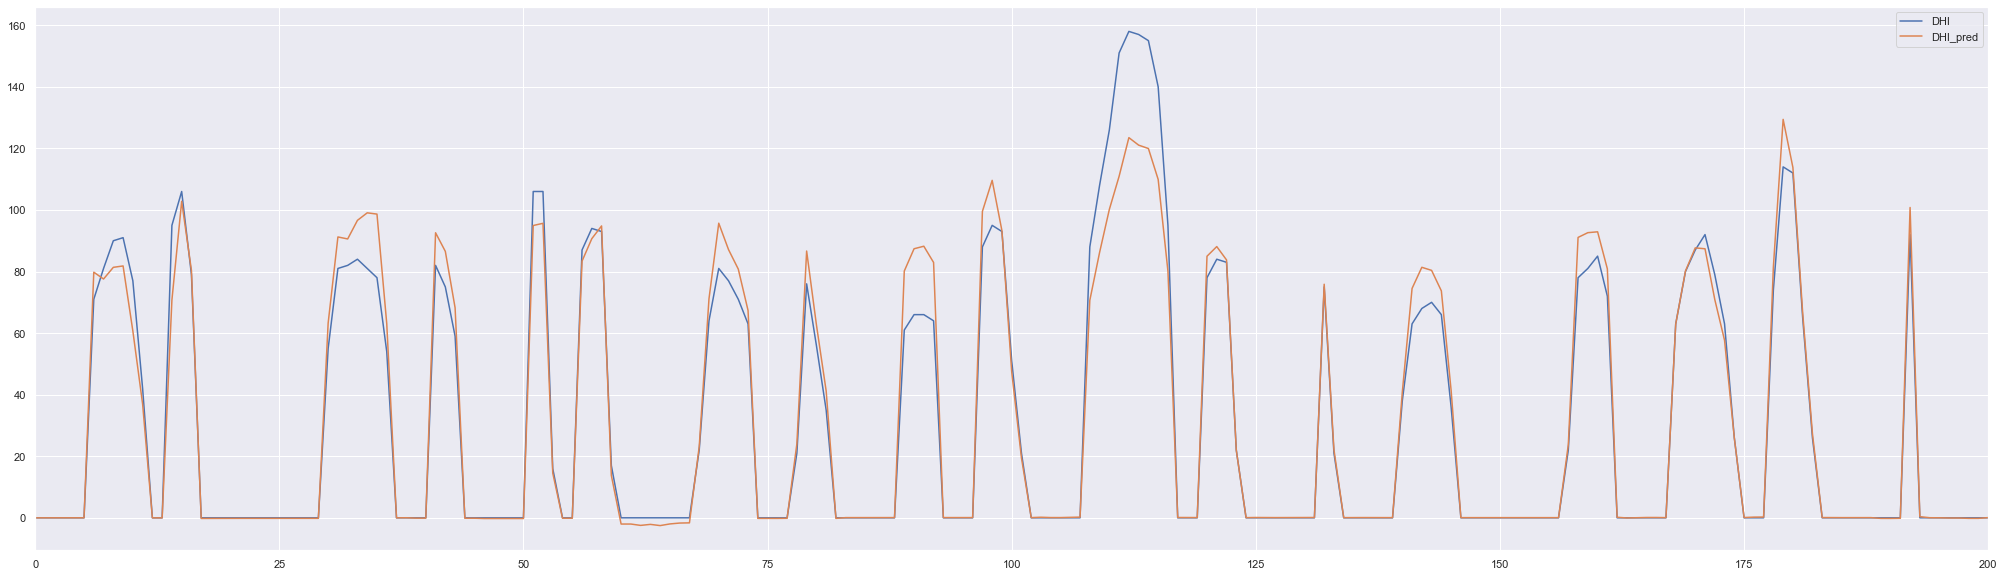

In [43]:
plt.figure(figsize=(35,10))
oof_pred['DHI'][:201].plot()
oof_pred['DHI_pred'][:201].plot()
plt.legend()

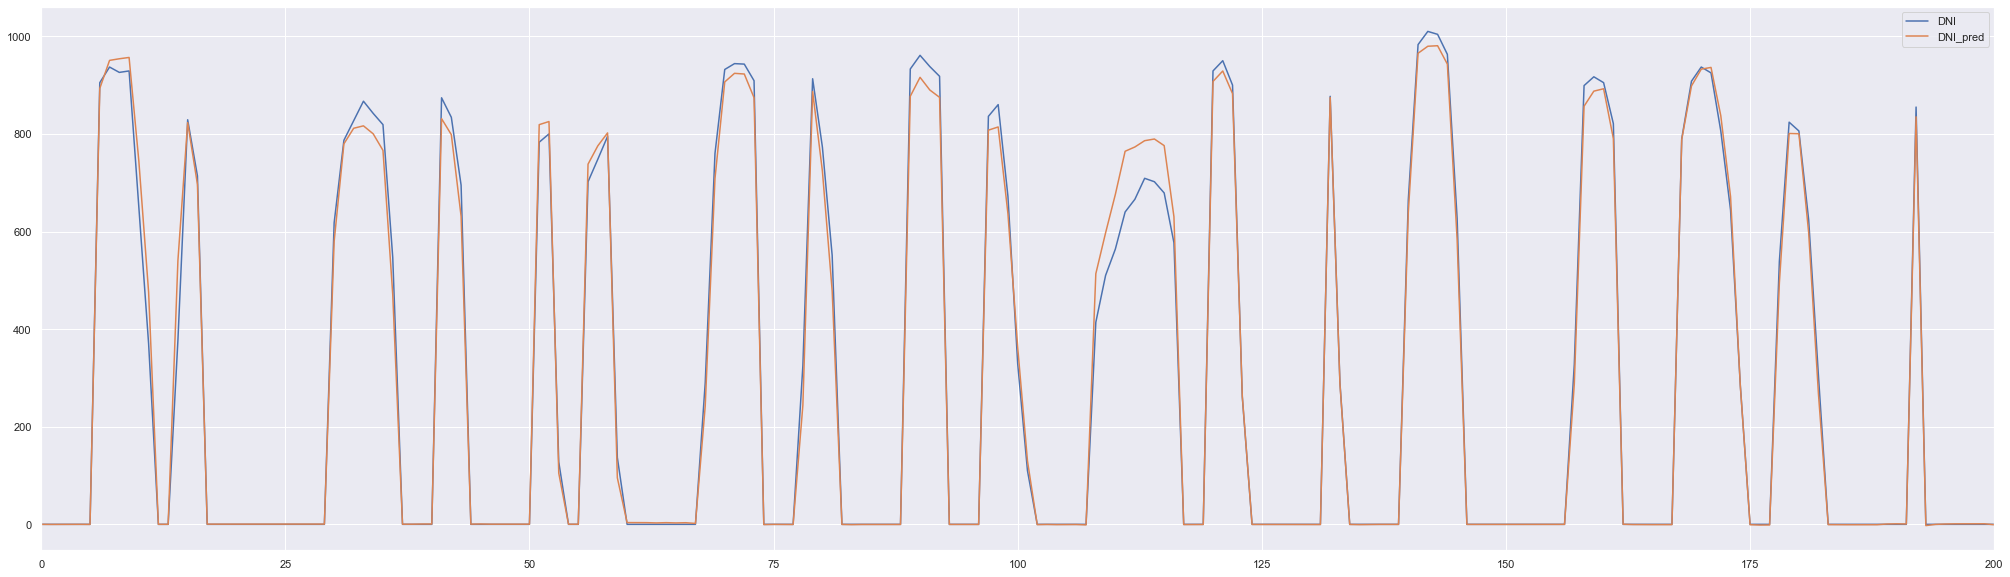

In [44]:
plt.figure(figsize=(35,10))
oof_pred['DNI'][:201].plot()
oof_pred['DNI_pred'][:201].plot()
plt.legend()

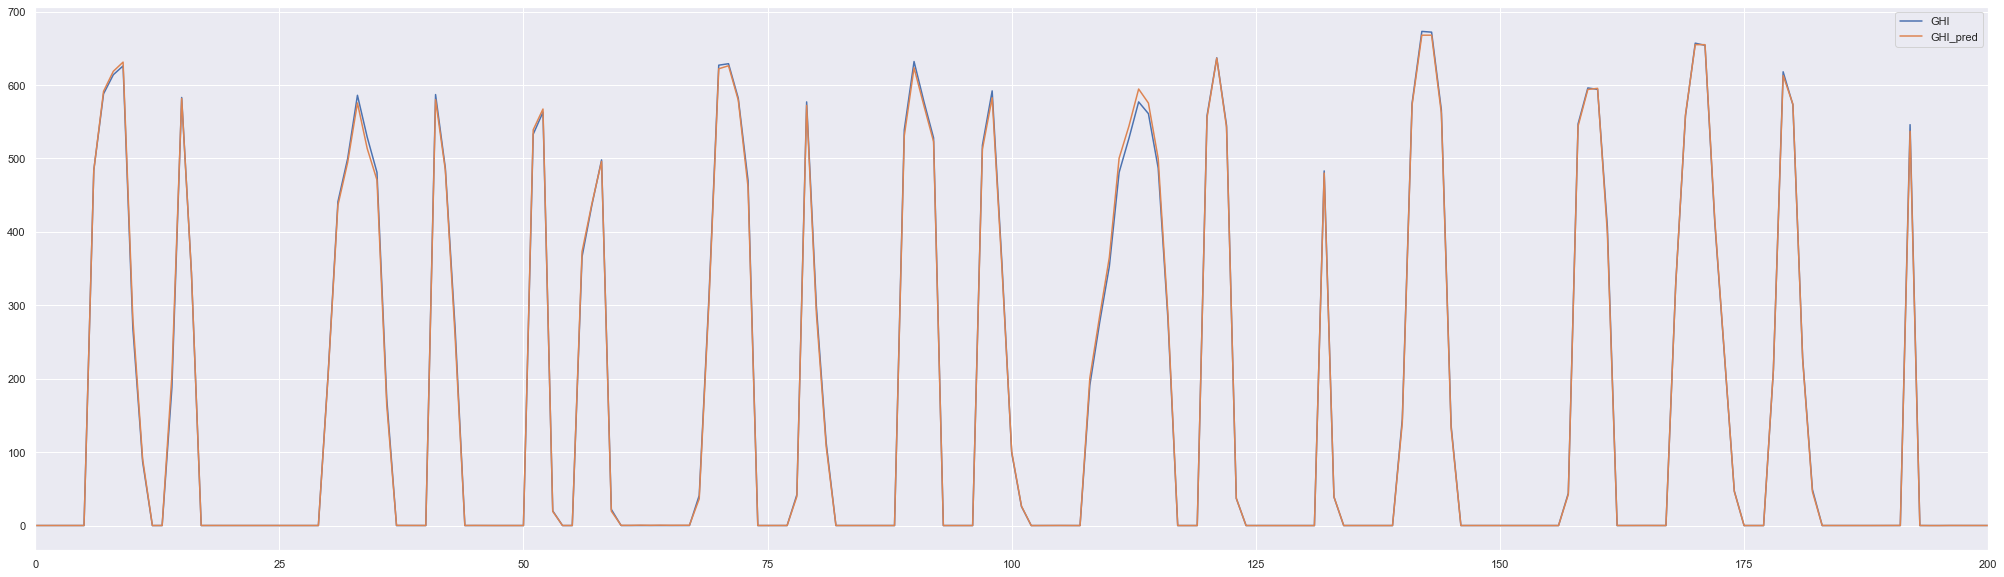

In [45]:
plt.figure(figsize=(35,10))
oof_pred['GHI'][:201].plot()
oof_pred['GHI_pred'][:201].plot()
plt.legend()

In [40]:
oof_pred.describe()

,DHI_pred,DNI_pred,GHI_pred
count,245416.000000,245416.000000,245416.000000
mean,53.089085,330.522308,254.651627
std,62.463848,368.354523,327.694946
min,-4.237723,-22.239443,-4.410034
25%,0.018834,0.082848,0.018663
50%,1.229009,2.428937,0.352372
75%,105.212753,740.533325,536.807648
max,546.609863,1020.433594,1046.451660


In [42]:
df.describe()

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Dew Point,Temperature,Pressure,Relative Humidity,Solar Zenith Angle,Precipitable Water,Wind Direction,Wind Speed,Fill Flag,fold
count,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000,175296.000000
mean,2013.500274,6.523549,15.727820,11.500000,15.000000,53.065426,330.065295,254.365490,2.540474,13.564431,18.266769,1003.185230,79.376366,89.729463,2.903732,188.877796,2.262871,0.740433,1.999989
std,2.871908,3.448543,8.799349,6.922206,15.000043,64.201407,370.030821,327.705006,3.021879,8.196787,8.943096,5.935749,19.678235,40.085451,1.546979,99.014733,1.281902,6.575655,1.414222
min,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.000000,-9.000000,970.000000,7.190000,8.550000,0.122000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,12.000000,1000.000000,65.590000,56.450000,1.534000,97.400000,1.300000,0.000000,1.000000
50%,2013.500000,7.000000,16.000000,11.500000,15.000000,0.000000,0.000000,0.000000,1.000000,15.000000,20.000000,1000.000000,84.230000,89.860000,2.866000,200.000000,2.000000,0.000000,2.000000
75%,2016.000000,10.000000,23.000000,17.250000,30.000000,103.000000,736.000000,535.000000,6.000000,21.000000,25.000000,1010.000000,97.950000,123.060000,4.223000,272.000000,3.000000,0.000000,3.000000
max,2018.000000,12.000000,31.000000,23.000000,30.000000,565.000000,1040.000000,1063.000000,10.000000,26.900000,40.000000,1024.000000,100.000000,171.550000,7.700000,360.000000,12.900000,100.000000,4.000000


In [48]:
oof_pred.loc[ oof_pred['DHI_pred'] < 0, 'DHI_pred'] = 0
oof_pred.loc[ oof_pred['DNI_pred'] < 0, 'DNI_pred'] = 0
oof_pred.loc[ oof_pred['GHI_pred'] < 0, 'GHI_pred'] = 0

In [51]:
oof_pred.describe()

,DHI_pred,DNI_pred,GHI_pred
count,245416.000000,245416.000000,245416.000000
mean,53.127567,330.668762,254.667557
std,62.430981,368.222748,327.682587
min,0.000000,0.000000,0.000000
25%,0.018834,0.082848,0.018663
50%,1.229009,2.428937,0.352372
75%,105.212753,740.533325,536.807648
max,546.609863,1020.433594,1046.451660


<AxesSubplot:xlabel='variable', ylabel='value'>

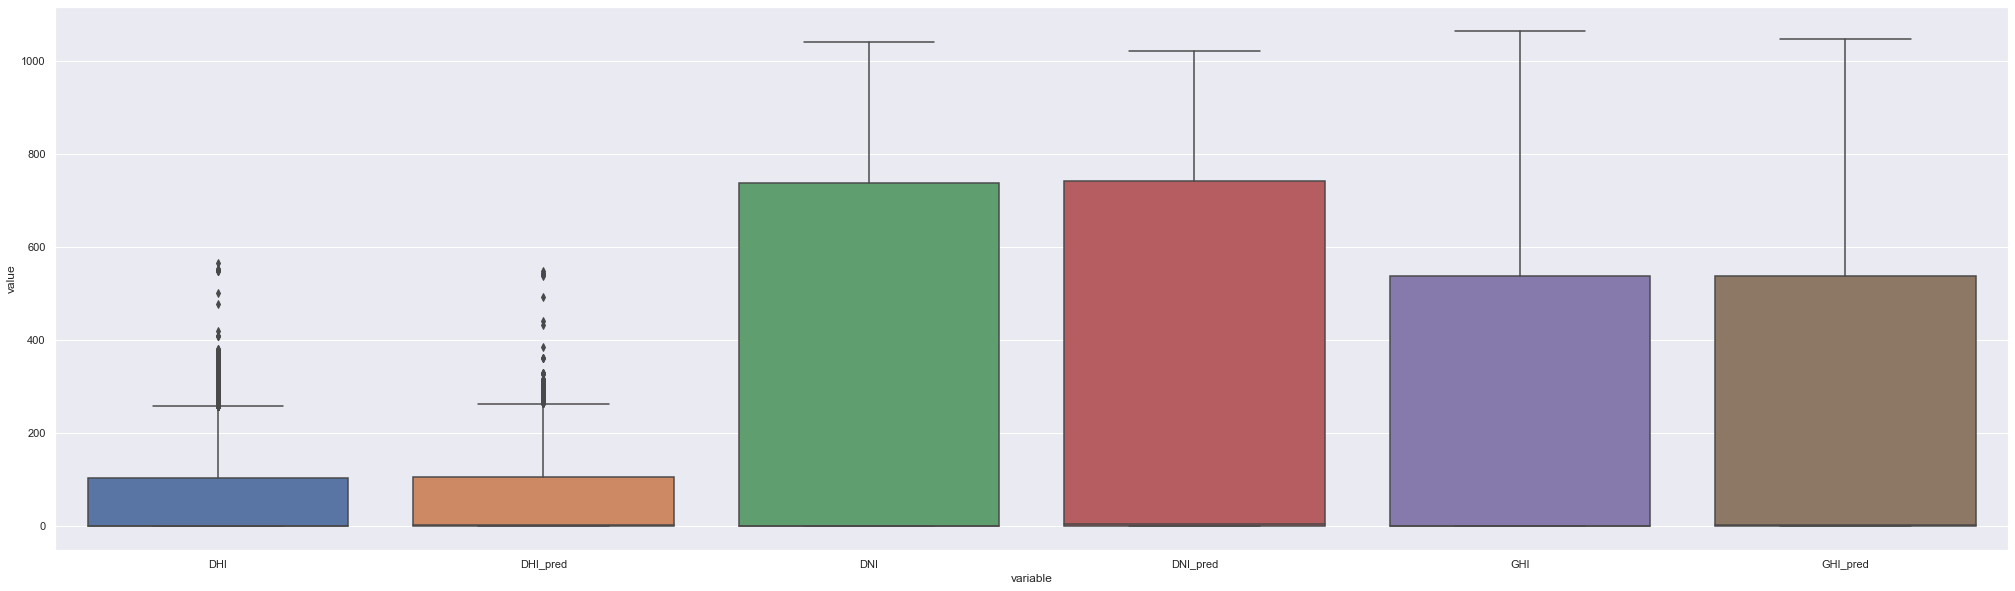

In [68]:
plt.figure(figsize=(35,10))
sns.boxplot(x="variable", y="value",data = pd.melt(oof_pred))

In [ ]:
# Test File

In [69]:
subFileDf = pd.DataFrame()

In [70]:
y_test_DHI = gbr1.predict(x_test)
y_test_DNI = gbr2.predict(x_test)
y_test_GHI = gbr3.predict(x_test)

In [71]:
subFileDf['Clearsky DHI'] = y_test_DHI
subFileDf['Clearsky DNI'] = y_test_DNI
subFileDf['Clearsky GHI'] = y_test_GHI

In [72]:
subFileDf.to_csv("xGBOOSTKF.csv, index=False")